In [1]:
import numpy.linalg as la

def nystroem_mmd(X, Y, kernel, m):
    n = len(X)
    #m = int(m_magnitude(n))
    m_idx = np.random.default_rng().integers(n, size=m)
    X_tilde = X[m_idx]
    Y_tilde = Y[m_idx]
    
    XX = kernel(X_tilde, X_tilde)
    YY = kernel(Y_tilde, Y_tilde)
    XY = kernel(X_tilde, Y_tilde)
    
    X_mn = kernel(X_tilde, X)
    Y_mn = kernel(Y_tilde, Y)
    
    alpha_1 = 1 / n * la.pinv(XX) @ X_mn @ np.ones((n, 1))
    alpha_2 = 1 / n * la.pinv(YY) @ Y_mn @ np.ones((n, 1))
    return (alpha_1.T @ XX @ alpha_1 + alpha_2.T @ YY @ alpha_2 - 2 * alpha_1.T @ XY @ alpha_2)[0][0]

In [11]:
import numpy as np
from sklearn import metrics


class MMD:
    def __init__(self, biased, gamma=1):
        """ """
        self.biased = biased
        self.gamma = gamma

    def mmd(self, X, Y):
        """Maximum Mean Discrepancy of X and Y."""
        if self.biased:
            XX = metrics.pairwise.rbf_kernel(X, X, self.gamma)
            YY = metrics.pairwise.rbf_kernel(Y, Y, self.gamma)
            XY = metrics.pairwise.rbf_kernel(X, Y, self.gamma)
            return XX.mean() + YY.mean() - 2 * XY.mean()
        else:
            m = len(X)
            n = len(Y)
            XX = metrics.pairwise.rbf_kernel(X, X, self.gamma) - np.identity(m)
            YY = metrics.pairwise.rbf_kernel(Y, Y, self.gamma) - np.identity(n)
            XY = metrics.pairwise.rbf_kernel(X, Y, self.gamma)
            return (
                1 / (m * (m - 1)) * np.sum(XX)
                + 1 / (n * (n - 1)) * np.sum(YY)
                - 2 * XY.mean()
            )

    def threshold(self, m, n, alpha=0.1):
        K = 1
        if self.biased:
            thresh = (
                np.sqrt(K / m + K / n)
                + np.sqrt((2 * K * (m + n) * np.log(1 / alpha)) / (m * n))
            ) ** 2

            return thresh  # square to be consistent with unbiased threshold
        else:
            raise NotImplementedError

    def threshold_old(self, m, n, alpha=0.1):
        """Using the original corollary from the paper (corollary 9)"""
        K = 1
        m = max(m, n)
        if self.biased:
            return (
                np.sqrt(2 * K / m) * (1 + np.sqrt(2 * np.log(1 / alpha)))
            ) ** 2  # square to be consistent with unbiased threshold
        else:
            return (4 * K / np.sqrt(m)) * np.sqrt(np.log(1 / alpha))

    def accept_H0(self, X, Y, alpha=0.1):
        """Test whether the distributions of X and Y are the same with significance alpha. True if both distributions are the same."""
        return self.mmd(X, Y) < self.threshold(len(X), len(Y), alpha=alpha)

    @staticmethod
    def estimate_gamma(X, n_samples=200, seed=1234):
        """Estimate the gamma parameter based on the median heuristic for sigma**2."""
        rng = np.random.default_rng(seed)
        distances = []
        for _ in range(n_samples):
            distances += [np.linalg.norm(rng.choice(X, size=2)) ** 2]
            sigma = np.median(distances)
        return 1 / np.sqrt(2 * sigma) if sigma > 0 else 1

In [2]:
def quadratic_time_mmd(X,Y,kernel):
    assert X.ndim == Y.ndim == 2
    K_XX = kernel(X,X)
    K_XY = kernel(X,Y)
    K_YY = kernel(Y,Y)
       
    n = len(K_XX)
    m = len(K_YY)
    
    # IMPLEMENT: unbiased MMD statistic (could also use biased, doesn't matter if we use permutation tests)
    np.fill_diagonal(K_XX, 0)
    np.fill_diagonal(K_YY, 0)
    mmd = np.sum(K_XX) / (n*(n-1))  + np.sum(K_YY) / (m*(m-1))  - 2*np.sum(K_XY)/(n*m)
    return mmd

In [14]:
#Incremental subsampling for quadratic MMD
import numpy as np
from sklearn.metrics.pairwise import rbf_kernel
from scipy.interpolate import interp1d
import math
np.random.seed(1)
calc = MMD(True)
sample_size = 1000
subsample_size = 2 * round(math.sqrt(sample_size))
subsubsample_size = 2 * round(math.sqrt(subsample_size))
mu1, sigma1 = 0, 1
sample1 = np.random.normal(mu1, sigma1, 1000)
mu2, sigma2 = 1, 2
sample2 = np.random.normal(mu2, sigma2, 1000)


sample1 = np.asarray([sample1]).reshape(-1, 1)
sample2 = np.asarray([sample2]).reshape(-1, 1)

print(quadratic_time_mmd(sample1, sample2, rbf_kernel))
#print(nystroem_mmd(sample1, sample2, rbf_kernel, 10))


subsample1 = np.random.choice(sample1.flatten(), size=subsample_size, replace=True)
subsample2 = np.random.choice(sample2.flatten(), size=subsample_size, replace=True)
subsample1 = np.asarray([subsample1]).reshape(-1, 1)
subsample2 = np.asarray([subsample2]).reshape(-1, 1)

print(calc.mmd(subsample1, subsample2))
#print(nystroem_mmd(sample1, sample2, rbf_kernel, 10))

subsubsample1 = np.random.choice(subsample1.flatten(), size=subsubsample_size, replace=True)
subsubsample2 = np.random.choice(subsample2.flatten(), size=subsubsample_size, replace=True)
subsubsample1 = np.asarray([subsubsample1]).reshape(-1, 1)
subsubsample2 = np.asarray([subsubsample2]).reshape(-1, 1)
print(calc.mmd(subsubsample1, subsubsample2))
#print(nystroem_mmd(sample1, sample2, rbf_kernel, 10))

0.1465852478073476
0.11081349943030472
0.1497195294129976


In [48]:

sample_size = 1000
subsample_size = 2 * round(math.sqrt(sample_size))
subsubsample_size = 2 * round(math.sqrt(subsample_size))
mu1, sigma1 = 0, 1
sample1 = np.random.normal(mu1, sigma1, 1000)
mu2, sigma2 = 1, 2
sample2 = np.random.normal(mu2, sigma2, 1000)

sample1 = np.asarray([sample1]).reshape(-1, 1)
sample2 = np.asarray([sample2]).reshape(-1, 1)

n_repeats = 10  # Number of times to repeat the calculation
nystroem_scores = {"n": [], "√2n": [], "√(2*√2n)": []}

for _ in range(n_repeats):
    nystroem_scores["n"].append(nystroem_mmd(sample1, sample2, rbf_kernel, sample_size))
    nystroem_scores["√2n"].append(nystroem_mmd(sample1, sample2, rbf_kernel, subsample_size))
    nystroem_scores["√(2*√2n)"].append(nystroem_mmd(sample1, sample2, rbf_kernel, subsubsample_size))

names = list(nystroem_scores.keys())
scores = np.array(list(nystroem_scores.values()))

mean_scores = np.mean(scores, axis=1)
std_scores = np.std(scores, axis=1)



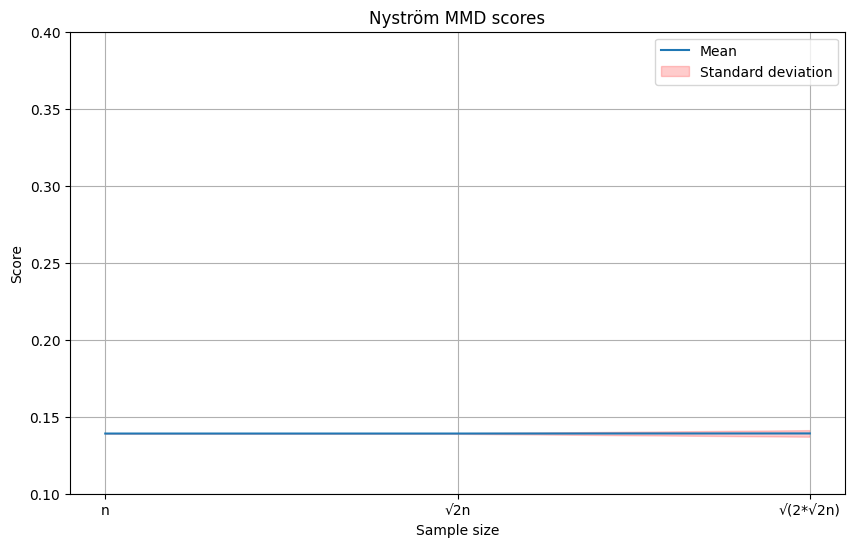

In [49]:
import matplotlib.pyplot as plt
numeric_index = np.arange(len(mean_scores))

mean_scores_np = np.array(mean_scores)
std_scores_np = np.array(std_scores)


f1 = interp1d(numeric_index, mean_scores_np - std_scores_np, kind='linear')
f2 = interp1d(numeric_index, mean_scores_np + std_scores_np, kind='linear')

plt.figure(figsize=(10, 6))

plt.plot(names, mean_scores,  label='Mean')

xnew = np.linspace(numeric_index.min(), numeric_index.max(), num=1000, endpoint=True)

plt.fill_between(xnew, f1(xnew), f2(xnew), alpha=0.2,label='Standard deviation', color="red")

plt.title('Nyström MMD scores')
plt.xlabel('Sample size')
plt.ylabel('Score')
plt.legend()
plt.grid(True)

# Adjust x-ticks to match names
plt.xticks(ticks=numeric_index, labels=names)

plt.ylim(0.1, 0.4)

plt.savefig('nystroem_scores.svg', format='svg')
plt.show()

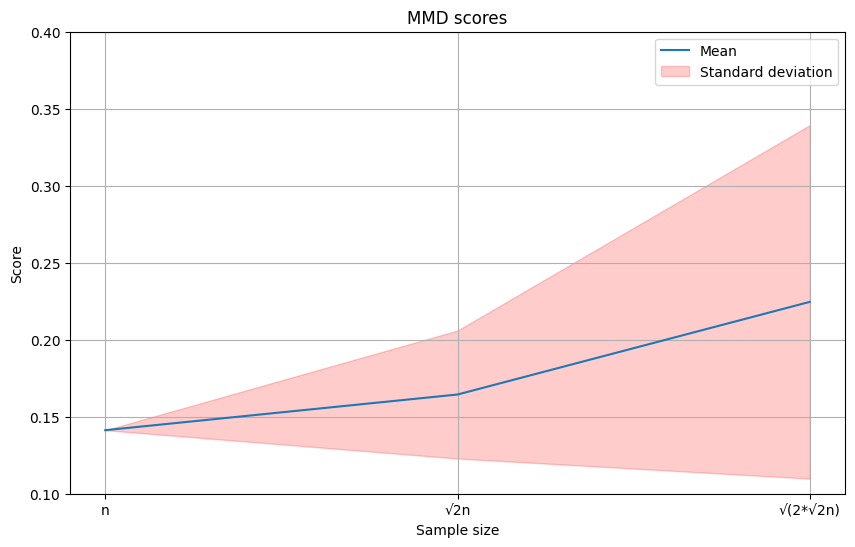

In [46]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

np.random.seed()
calc = MMD(True)
sample_size = 1000
subsample_size = 2 * round(math.sqrt(sample_size))
subsubsample_size = 2 * round(math.sqrt(subsample_size))
mu1, sigma1 = 0, 1
sample1 = np.random.normal(mu1, sigma1, 1000)
mu2, sigma2 = 1, 2
sample2 = np.random.normal(mu2, sigma2, 1000)

sample1 = np.asarray([sample1]).reshape(-1, 1)
sample2 = np.asarray([sample2]).reshape(-1, 1)

n_repeats = 50  # Number of times to repeat the calculation
mmd_scores = {"n": [], "√2n": [], "√(2*√2n)": []}

for _ in range(n_repeats):
    subsample1 = np.random.choice(sample1.flatten(), size=subsample_size, replace=True)
    subsample2 = np.random.choice(sample2.flatten(), size=subsample_size, replace=True)
    subsample1 = np.asarray([subsample1]).reshape(-1, 1)
    subsample2 = np.asarray([subsample2]).reshape(-1, 1)

    subsubsample1 = np.random.choice(subsample1.flatten(), size=subsubsample_size, replace=True)
    subsubsample2 = np.random.choice(subsample2.flatten(), size=subsubsample_size, replace=True)
    subsubsample1 = np.asarray([subsubsample1]).reshape(-1, 1)
    subsubsample2 = np.asarray([subsubsample2]).reshape(-1, 1)

    mmd_scores["n"].append(calc.mmd(sample1, sample2))
    mmd_scores["√2n"].append(calc.mmd(subsample1, subsample2))
    mmd_scores["√(2*√2n)"].append(calc.mmd(subsubsample1, subsubsample2))

names = list(mmd_scores.keys())
scores = np.array(list(mmd_scores.values()))

mean_scores = np.mean(scores, axis=1)
std_scores = np.std(scores, axis=1)

numeric_index = np.arange(len(mean_scores))

mean_scores_np = np.array(mean_scores)
std_scores_np = np.array(std_scores)

f1 = interp1d(numeric_index, mean_scores_np - std_scores_np, kind='linear')
f2 = interp1d(numeric_index, mean_scores_np + std_scores_np, kind='linear')

plt.figure(figsize=(10, 6))
plt.plot(names, mean_scores, label='Mean')
xnew = np.linspace(numeric_index.min(), numeric_index.max(), num=1000, endpoint=True)
plt.fill_between(xnew, f1(xnew), f2(xnew), alpha=0.2, label='Standard deviation', color="red")

plt.title('MMD scores')
plt.xlabel('Sample size')
plt.ylabel('Score')
plt.legend()
plt.grid(True)

plt.ylim(0.1, 0.4) 

# Adjust x-ticks to match names
plt.xticks(ticks=numeric_index, labels=names)

plt.savefig('mmd_scores.svg', format='svg')  # Save the plot as SVG file

plt.show()


In [7]:
mean_scores

array([0.13612722, 0.13065805, 0.23721556])

In [8]:
std_scores

array([2.77555756e-17, 4.92830314e-02, 1.70189717e-01])

In [9]:
#don't really know how to do this
def nystroem_mmd_updatable(X, Y, kernel, m):
    n = len(X)
    #m = int(m_magnitude(n))
    m_idx = np.random.default_rng().integers(n, size=m)
    X_tilde = X[m_idx]
    Y_tilde = Y[m_idx]
    
    XX = kernel(X_tilde, X_tilde)
    YY = kernel(Y_tilde, Y_tilde)
    XY = kernel(X_tilde, Y_tilde)
    
    X_mn = kernel(X_tilde, X)
    Y_mn = kernel(Y_tilde, Y)
    
    alpha_1 = 1 / n * la.pinv(XX) @ X_mn @ np.ones((n, 1))
    alpha_2 = 1 / n * la.pinv(YY) @ Y_mn @ np.ones((n, 1))
    return (alpha_1.T @ XX @ alpha_1 + alpha_2.T @ YY @ alpha_2 - 2 * alpha_1.T @ XY @ alpha_2)[0][0], X_tilde, Y_tilde, alpha_1, alpha_2

In [10]:
from scipy.optimize import minimize
import numpy as np

def objective(gamma, alpha, beta, B1_sample, B2_sample, m, k):
    term1 = np.dot(alpha, func(B1_sample)) + np.dot(beta, func(B2_sample))
    term2 = np.dot(gamma, func(k[:m]))
    return np.abs(term1 - term2)**2

#really not sure how to do this yet
def update_weights(B1_sample, alpha, B2_sample, beta, m):
    combined_samples = np.concatenate((B1_sample, B2_sample))
    k = np.random.choice(combined_samples, m, replace=False)
    gamma_initial = np.random.rand(m)
    cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x)-1})
    bnds = [(0,1) for _ in range(m)]
    
    result = minimize(objective, gamma_initial, args=(alpha, beta, B1_sample, B2_sample, m, k),
                      method='SLSQP', bounds=bnds, constraints=cons)
    return result.x
